# Sklearn: Classification

In [66]:
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score as AUC, fbeta_score as FScore
import dtreeviz

np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

## 1. K-Nearest Neighbors

### 1.1. Algorithm
[K-NN] ($K$-Nearest Neighbors) does not actually *learn* anything, it only *saves* all training data point. When predicting the label for a new query point $\mathbf{s}_q$, the model first measures the distance $d_n$ from each training point $\mathbf{s}_n$ ($n=1,2,\dots,N$) to $\mathbf{s}_q$. Then, select $K$ points with smallest distance and do majority/weighted voting to determine which class the query point belongs to. For weighted voting, the query point will fall into the class with the highest total of weight. The corresponding weight of the observation $\mathbf{s}_k$ is $\displaystyle{w_k=1/d_k}$ ($k=1,2,\dots,K$). Majority voting can be thought as weighted voting where all sample weights are set to $1/K$.

K-NN can also predict the probability that the query point falls into a specific class by computing the ratio between the total weights of those neighbors who support that class over the total weights of all $K$ neighbors.

[K-NN]: https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

#### Distance metrics
Some popular [distance metrics] being used in K-NN are:
- [Manhattan distance], measures the total distance of going along side every axis.
- [Euclidean distance], measures the direct distance.
- [Mahalanobis distance], same as Euclidean but variables are scaled and transformed to be uncorrelated.
- [Cosine distance], measures how large the angle between two vectors is.

However, Euclidean distance is the most common method:

$$d_n = \sqrt{(x_{1n}-x_{1q})^2+(x_{2n}-x_{2q})^2+\dots}$$

[distance metrics]: https://en.wikipedia.org/wiki/Metric_(mathematics)
[Manhattan distance]: https://en.wikipedia.org/wiki/Taxicab_geometry
[Euclidean distance]: https://en.wikipedia.org/wiki/Euclidean_distance
[Mahalanobis distance]: https://en.wikipedia.org/wiki/Mahalanobis_distance
[Cosine distance]: https://en.wikipedia.org/wiki/Cosine_similarity

### 1.2. Implementation
Scikit-learn implements K-NN via the class <code style="font-size:13px">[KNeighborsClassifier]</code>.

[KNeighborsClassifier]: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
from util import dt, np, pd, skl
from sklearn import metrics

In [5]:
model = ml.KNNClassifier()
metrics.cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc')

array([0.94788442, 0.93111455, 0.96362229, 0.97291022, 0.95923633])

#### Hyperparameters
- <code style="font-size:13px">n_neighbors</code>: the number of neighbors who vote for the label ($K$), defaults to *5*.
- <code style="font-size:13px">weights</code>: the voting strategy, defaults to *uniform* (majority voting). Can be set to *distance* for weighted voting.
- <code style="font-size:13px">metrics</code>: the type of distance metric, defaults to *euclidean*. Other options are *manhattan*, *mahalanobis*, *minkowski* and *chebyshev*. Also accepts customized metrics with the signature
<code style="font-size:13px">func(x, y) -> distance</code>,
beside [bulit-in ones](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html).

In [4]:
df_cancer = pd.read_csv('../data/breast_cancer.csv')
x = df_cancer.drop(columns='target')
y = df_cancer.target
x_train, x_test, y_train, y_test = ml.train_test_split(x, y, test_size=0.2, random_state=1)

In [3]:
start = dt.datetime.now()

def cosine_distance(x, y):
    from numpy.linalg import norm
    return 1 - x @ y / (norm(x, 2) * norm(y, 2))

space1 = {
    'n_neighbors': np.arange(3, 11),
    'weights': ['uniform', 'distance'],
    'metric': [cosine_distance],
}

space2 = {
    'n_neighbors': np.arange(3, 11),
    'weights': ['uniform', 'distance'],
    'metric': ['mahalanobis'],
    'metric_params': [{'VI': np.cov(x_train)}]
}

space3 = {
    'n_neighbors': np.arange(3, 11),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2, 3, 4, 5],
}

params = [space1, space2, space3]

algo = ml.KNNClassifier()
validator = ml.GridSearchCV(algo, params, cv=5, scoring='roc_auc')

validator = validator.fit(x_train, y_train)
model = validator.best_estimator_

end = dt.datetime.now()
print(end - start)

0:00:45.142652


In [68]:
validator.best_params_

{'metric': 'minkowski', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

In [69]:
y_test_pred = model.predict_proba(x_test)[:, model.classes_==1]
auc_test = metrics.roc_auc_score(y_test, y_test_pred)
model_name = model.__class__.__name__

print(f'AUC = {auc_test:.4f} [{model_name}]')

AUC = 0.9730 [KNeighborsClassifier]


#### Model structure
Here are the information you can extract from a K-NN model fit by Scikit-learn:
- <code style="font-size:13px">[kneighbors()]</code> method: find the $K$ neighbors and their corresponding distances of query points.
- <code style="font-size:13px">[kneighbors_graph()]</code> method: compute the weighted graph of $K$ neighbors for query points.

[kneighbors()]: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors
[kneighbors_graph()]: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors_graph

In [25]:
neighbor_distance, neighbor_index = model.kneighbors(x_test)
neighbor_distance.shape

(114, 9)

In [31]:
graph = model.kneighbors_graph(x_test, mode='distance').toarray()
graph.shape

(114, 455)

## 2. Decision Tree

### 2.1. Algorithm
[Decision Tree] is a method aiming to find a set of if-else statements to build a preditive model, visualized as a hierarchy diagram. There has been several Decision Tree algorithms invented throught out the history, notably include:
- [ID3], an algorithm that creates a multiway classification tree using [information gain] principle and works only on categorical variables.
- [C4.5], the successor of ID3, makes a number of improvements: (1) accepting continuous variables using thresholdList, (2) ignoring missing values in the calculation of information gain and (3) introducing tree pruning.
- [CART], a similar algorithm to C4.5 but it only grows binary trees and supports regression problems. This is the algorithm used in Scikit-learn.

[Decision Tree]: https://en.wikipedia.org/wiki/Decision_tree_learning
[ID3]: https://en.wikipedia.org/wiki/ID3_algorithm
[information gain]: https://en.wikipedia.org/wiki/Information_gain_in_decision_trees
[C4.5]: https://en.wikipedia.org/wiki/C4.5_algorithm
[CART]: https://en.wikipedia.org/wiki/Predictive_analytics#Classification_and_regression_trees_(CART)

#### Tree components
In a Decision Tree, a node is the representation of data. The data is then split using a variable and a split condition. A node is a parent node if it is split, the smaller nodes after splitting it are child nodes. Here are the components of a tree:
- Root node: the topmost node, represents the entire data
- Leaf node (terminal node): the node that is not split further and predicts the label
- Internal node: any node other than leaf nodes
- Edge: the specific criterion to split a node
- Branch: represents a sub-tree which considers an internal node as root node

<img src="../image/chap-06/tree-components.png" style="height:200px; margin:20px auto 20px;">

#### Measures of impurity
The ultimate goal of Decision Tree is to construct a tree having leaf nodes as *pure* as possible. A node is considered *pure* if most of its observations fall into a single class. In contrast, an *impure* node distributes its observations equally into different classes. In this section, we learn about some quality metrics that measure the *impurity* of a node. These metrics should be designed so that the higher values they are, the less pure a node is.

Let's say at a node, the probability (ratio) that an observation falls into a class $\mathcal{C}_m$ is $p_m$. Here are the two measures of impurity:

- $\displaystyle{\text{Entropy} = -\sum_{m=1}^{M}{p_m\log{p_m}}}$

- $\displaystyle{\text{Gini} = 1-\sum_{m=1}^{M}{p_m^2}}$

Now let's graph these functions for the most simple case: binary classification. Despite that there are 2 classes, we only need to plot against the ratio of positive class.

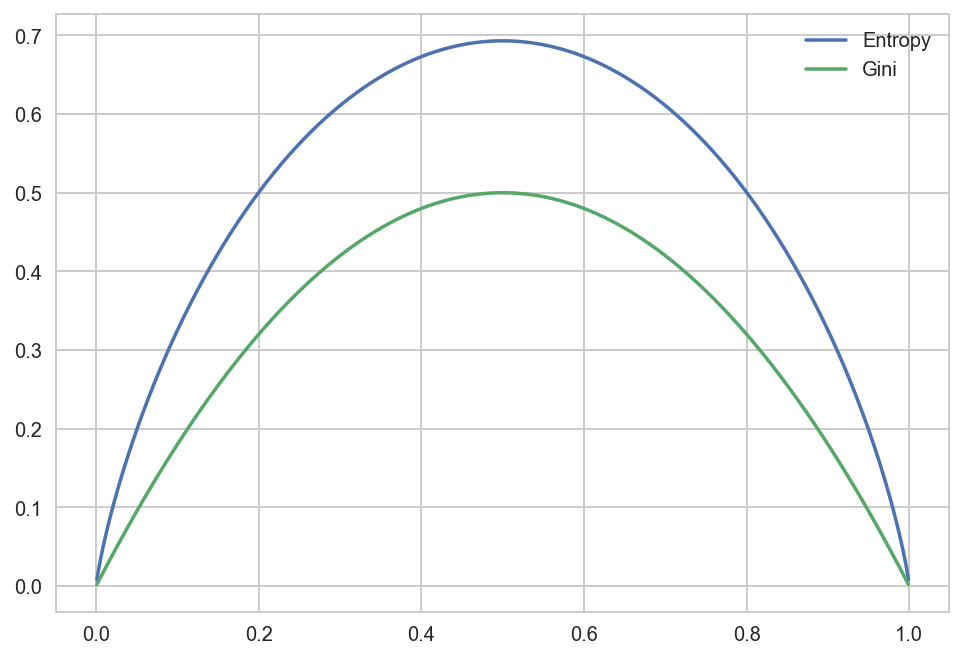

In [1]:
from util import np, plt

error = 1e-3
bound_left, bound_right = 0, 1
bound_left, bound_right = bound_left + error, bound_right - error

p = np.linspace(bound_left, bound_right, 1000)
q = 1 - p

entropy = -(p * np.log(p) + q * np.log(q))
gini = 1 - (p**2 + q**2)

fig, ax = plt.subplots()
ax.plot(p, entropy, label='Entropy')
ax.plot(p, gini, label='Gini')
ax.legend()
plt.show()

#### Algorithm details
*Input*
- A dataset of numerical features
- A quality function 
- Stopping criteria (optional)

*Step 1*. For each unsplit node $\mathcal{D}$ (starting from the root node):
- Compute the impurity of node $\mathcal{D}$.
- For each candiate (which is a combination a feature and a threshold), split node $D$ into 2 smaller nodes, $\mathcal{D}_{\text{left}}$ and $\mathcal{D}_{\text{right}}$.
- Calculate the impurity for child nodes and information gain for the candidate:
    
$$
    \text{InfoGain}=
    \text{Impurity}_{\text{parent}}-
    \left(
        \frac{|\mathcal{D}_{\text{left}}|}{|\mathcal{D}|}\,\text{Impurity}_{\text{left}}+
        \frac{|\mathcal{D}_{\text{right}}|}{|\mathcal{D}|}\,\text{Impurity}_{\text{right}}
    \right)
$$

- Choose the candidate with the highest information gain. Split node $D$ using that candidate.

*Step 2*. Go back and prune the tree  until all stopping conditions are met. The purpose of this step is to prevent overfitting. For example, you can set the minimum number of observations to perform a split to 20, the algorithm will find all branches whose root node is not large enough. For each branch, it removes the entire branch and keeps only the root node.

*Step 3*. Calculate the ratio of every class in every leaf node. These values are used as probability prediction.

### 2.2. Implementation
Scikit-learn implements Decision Tree via the class <code style="font-size:13px">[DecisionTreeClassifier]</code>.

[DecisionTreeClassifier]: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [ ]:
from util import dt, np, pd, plt, sns, skl
from sklearn import metrics
import dtreeviz

#### Hyperparameters
- <code style="font-size:13px">criterion</code>: the measure of quality of a split, defaults to *gini*. The other option is *entropy*.
- <code style="font-size:13px">max_depth</code>: the maximum depth of the tree, defaults to *None* (no limitations).
- <code style="font-size:13px">max_leaf_nodes</code>: the maximum number of leaf nodes, defaults to *None* (no limitations).
- <code style="font-size:13px">min_samples_split</code>: the minimum number (if integer) or ratio (if float) of instances in a node to split, defautls to *2*.
- <code style="font-size:13px">min_samples_leaf</code>: the minimum number (integer) or ratio (float) of instances a leaf node must have, deafaults to *1*.
- <code style="font-size:13px">min_weight_fraction_leaf</code>: the minimum sum of instance weights a node must have, defaults to *0*.
- <code style="font-size:13px">min_impurity_decrease</code>: a split will be performed if its information gain is not less than this value, defaults to *0*.

In [51]:
df_cancer = pd.read_csv('../data/breast_cancer.csv')
x = df_cancer.drop(columns='target')
y = df_cancer.target
x_train, x_test, y_train, y_test = ml.train_test_split(x, y, test_size=0.2, random_state=1)

In [52]:
start = dt.datetime.now()

params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,6),
    'random_state': [2],
}

algo = ml.DecisionTreeClassifier()
validator = ml.GridSearchCV(algo, params, cv=5, scoring='roc_auc')
validator = validator.fit(x_train, y_train)
model = validator.best_estimator_

print(dt.datetime.now() - start)

0:00:00.300512


In [53]:
validator.best_params_

{'criterion': 'gini', 'max_depth': 4, 'random_state': 2}

In [54]:
y_test_pred = model.predict_proba(x_test)[:, model.classes_==1]
auc_test = metrics.roc_auc_score(y_test, y_test_pred)
model_name = model.__class__.__name__

print(f'AUC = {auc_test:.4f} [{model_name}]')

AUC = 0.9373 [DecisionTreeClassifier]


#### Feature importances
Decision Tree supports computing feature importances by taking the total information gain brought by each feature. This can be extracted using the <code style="font-size:13px">[feature_importances_]</code> attribute.

[feature_importances_]: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_

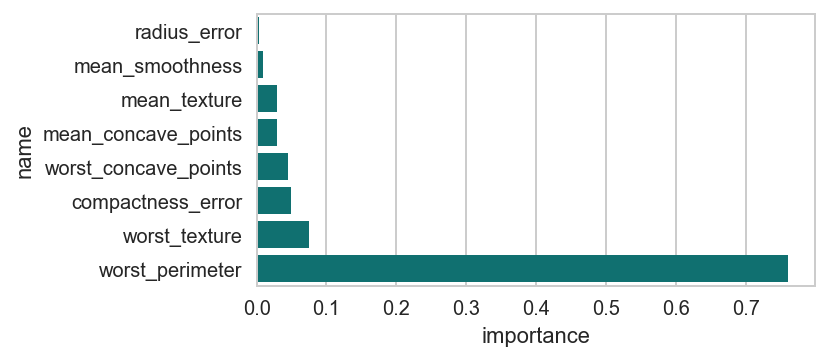

In [55]:
n_top = 10

df = pd.DataFrame({'name': model.feature_names_in_, 'importance': model.feature_importances_})
df = df.sort_values('importance')
df = df.query("importance > 0")
df = df.tail(n_top)

fig, ax = plt.subplots(figsize=(5,2.5))
sns.barplot(data=df, x='importance', y='name', color='teal')
plt.show()

#### Interpretation
Scikit-learn has two functions,
<code style="font-size:13px">[plot_tree()]</code> and
<code style="font-size:13px">[decision_path()]</code>
for visualization of the learned tree, but we are going to use a better library, [dtreeviz] to do this task.

[plot_tree()]: https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
[decision_path()]: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.decision_path
[dtreeviz]: https://github.com/parrt/dtreeviz

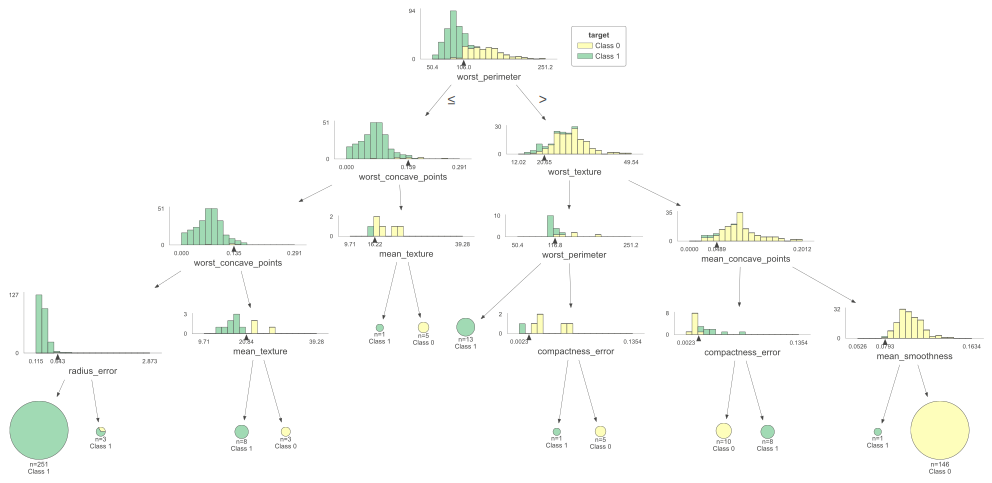

In [62]:
explainer = dtreeviz.model(model, x_train, y_train, target_name=y.name, feature_names=x.columns)
explainer.view()

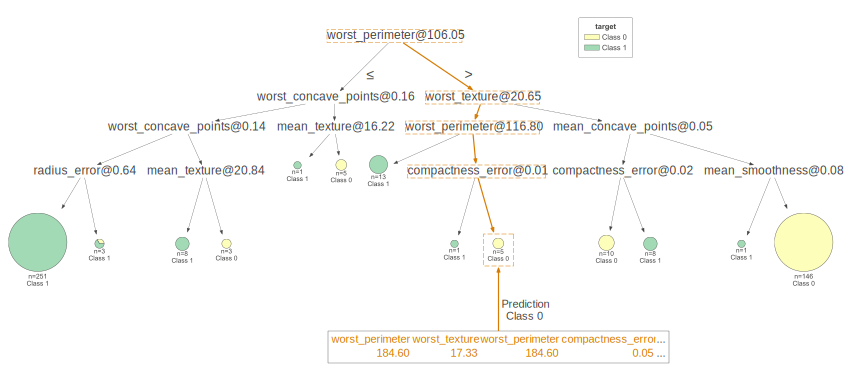

In [64]:
sample = x.iloc[0, :]
explainer.view(x=sample, fancy=False)

#### Multilabel problem
Decision Tree, as well as some other tree-based algorithms, can be extended to *multi-label* problems, including both regression and classification. The term *multi-label* is also known as *multi-output*, but is different from *multi-class*.

In [11]:
df_emotion_train = pd.read_csv('../data/emotions_train.csv')
df_emotion_test = pd.read_csv('../data/emotions_test.csv')

x_train = df_emotion_train.iloc[:, :-6]
y_train = df_emotion_train.iloc[:, -6:]
x_test = df_emotion_test.iloc[:, :-6]
y_test = df_emotion_test.iloc[:, -6:]

print(x_train.shape, y_train.shape)

(391, 72) (391, 6)


In [12]:
start = dt.datetime.now()

params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,6),
    'random_state': [2],
}

algo = ml.DecisionTreeClassifier()
validator = ml.GridSearchCV(algo, params, cv=5, scoring='roc_auc')
validator = validator.fit(x_train, y_train)
model = validator.best_estimator_

print(dt.datetime.now() - start)

0:00:00.941082


In [42]:
y_test_prob = np.array(model.predict_proba(x_test))
y_test_prob = y_test_prob[:, :, 1].T
list_auc = metrics.roc_auc_score(y_test, y_test_prob, average=None)
list_auc = list_auc.round(4).tolist()

print(f'AUC = {list_auc} [{model.__class__.__name__}]')

AUC = [0.7801, 0.5942, 0.679, 0.8473, 0.707, 0.82] [DecisionTreeClassifier]


## 3. Naive Bayes

### 3.1. Algorithm
[Naive Bayes] is an algorithm based on the [Bayes' theorem]. In the context of classification, given $\mathbf{X}=\mathbf{x}_1,\mathbf{x}_2,\dots$ is the set of input variables and $\mathbf{y}$ is the output variable; the Bayes theorem can be written as:

$$P(\mathbf{y}|\mathbf{X}) = \frac{P(\mathbf{X}|\mathbf{y})P(\mathbf{y})}{P(\mathbf{X})}$$

- $P(\mathbf{y}|\mathbf{X})$ is the posterior probability, the probability of a class for given predictors
- $P(\mathbf{X}|\mathbf{y})$ is the likelihood, the probability of predictors for a given class
- $P(\mathbf{y})$ is the prior probability of a class
- $P(\mathbf{X})$ is the prior probability of predictors

This formula expresses how the algorithm classifies a new query point to the class $c$:

$$\hat{\mathbf{y}} = \arg\max P(\mathbf{y}=c|\mathbf{X}) =
\arg\max P(\mathbf{X}|\mathbf{y}=c)P(\mathbf{y}=c)$$

[Naive Bayes]: https://en.wikipedia.org/wiki/Naive_Bayes_classifier
[Bayes' theorem]: https://en.wikipedia.org/wiki/Bayes%27_theorem

#### Likelihood estimation
Naive Bayes assumes that $\mathbf{x}_1,\mathbf{x}_2,\dots$ are independent of each other. This assumption looks quite unrealistic, explains why the algorithm is considered naive. However, Naive Bayes performs surprisingly well in real-world classification problems. The likelihood can be written under this assumption:

$$P(\mathbf{x}_1,\mathbf{x}_2,\dots|\mathbf{y}) = \prod_{d=1}^{D}{P(\mathbf{x}_d|\mathbf{y})}$$

To estimate $P(\mathbf{x}_i|\mathbf{y})$, there are three distributions can be used, depending on the input data:
- [Gaussian distribution], used when the input data is continuous. The parameters $\mu_{\mathbf{y}}$ and $\sigma_{\mathbf{y}}$ are estimated using maximum likelihood.

$$P(\mathbf{x}_d|\mathbf{y}) = \frac{1}{\sqrt{2\pi\sigma^2_{\mathbf{y}}}} \exp\left(-\frac{(\mathbf{x}_d - \mu_{\mathbf{y}})^2}{2\sigma^2_{\mathbf{y}}}\right)$$

- [Multinomial distribution], used when the input data is categorical data. Widely used in text classification. In this formula, $N$ represents the number of observations, $\alpha$ represents the Laplace smooth coefficient, $K$ is the number of words. $\alpha=1$ is usually chosen, prevents the probability to be 0.

$$P(\mathbf{x}_d|\mathbf{y}) = \frac{N(\mathbf{x}_d|\mathbf{y})+\alpha}{N(\mathbf{y})+\alpha K}$$

- [Bernoulli distribution], used for binary input data.

$$P(\mathbf{x}_d|\mathbf{y}) = p_d^{\mathbf{x}_d}(1-p_d)^{1-\mathbf{x}_d}$$

[Gaussian distribution]: https://en.wikipedia.org/wiki/Normal_distribution
[Multinomial distribution]: https://en.wikipedia.org/wiki/Multinomial_distribution
[Bernoulli distribution]: https://en.wikipedia.org/wiki/Bernoulli_distribution

### 3.2. Implementation

In [10]:
from util import dt, np, pd, plt, sns, skl
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB, MultinomialNB

#### Tabular data
This section uses the breast cancer dataset, where input variables are continuous. For a mixed types dataset, we independently train
- <code style="font-size:13px">[GaussianNB]</code> for continuous features
- <code style="font-size:13px">[CategoricalNB]</code> for categorical features
- <code style="font-size:13px">[BernoulliNB]</code> for binary features

then stack their results by multiplication.

[GaussianNB]: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
[CategoricalNB]: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html
[BernoulliNB]: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html

In [11]:
df_cancer = pd.read_csv('../data/breast_cancer.csv')
x = df_cancer.drop(columns='target')
y = df_cancer['target']
x_train, x_test, y_train, y_test = ml.train_test_split(x, y, test_size=0.2, random_state=1)

In [12]:
start = dt.datetime.now()

params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,6),
    'random_state': [2],
}

algo = GaussianNB()
model = algo.fit(x_train, y_train)

print(dt.datetime.now() - start)

0:00:00.003376


In [13]:
y_test_pred = model.predict_proba(x_test)[:, model.classes_==1]
auc_test = metrics.roc_auc_socre(y_test, y_test_pred)
model_name = model.__class__.__name__

print(f'AUC = {auc_test:.4f} [{model_name}]')

AUC = 0.9772 [GaussianNB]


#### Text data
Text data is preprocessed so that columns represent words and row represents their number of occurrences (also known as count vectorization). <code style="font-size:13px">[MultinomialNB]</code> is suitable in this case.

[MultinomialNB]: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [14]:
x_train = np.array([
    [2, 2, 1, 0, 0, 0, 0, 0, 0],
    [1, 3, 0, 1, 2, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 2, 1, 1]
])
y_train = np.array(['A', 'A', 'A', 'B'])

x_test = np.array([
    [1, 2, 0, 1, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 1, 1]
])

In [15]:
algo = MultinomialNB()
model = algo.fit(x_train, y_train)
model.predict(x_test)

array(['A', 'B'], dtype='<U1')

## 4. Support Vector Machines

### 4.1. Algorithm
[Support Vector Machines] is a binary classification algorithm, aiming to find a hyperplane that best splits the data into two classes ($\mathbf{y}=1$ and $\mathbf{y}=-1$). SVM uses the following concepts:
- Support vector: the closest point from the separating hyperplane. There is at least one support vector in each class.
- Margin: the distance between a support vector and the separating hyperplane.

Notice that all support vectors should have the same distance from the decision boundary. In other words, the margins of both class are equal. It's quite clear to state that the larger the margin is, the better the algorithm classifies the data.

[Support Vector Machines]: https://en.wikipedia.org/wiki/Support-vector_machine

#### The loss function
Assume the equation of the separating hyperplane is $w_0+w_1\mathbf{x}_1+w_2\mathbf{x}_2+\dots=0$. Denote $\mathbf{w}=(w_1,w_2,\dots)$ and $\mathbf{X}=(\mathbf{x}_1,\mathbf{x}_2,\dots)$, the boundary can be rewritten as $w_0+\mathbf{w}\mathbf{X}=0$. Now do some transformations so that the equations of the two edges (hyperplanes that are parallel to the boundary and go through the support vectors) are $w_0+\mathbf{w}\mathbf{X}=1$ and $w_0+\mathbf{w}\mathbf{X}=-1$.

<img src="../image/chap-06/svm-hard.png" style="height:300px; margin:20px auto 20px;">

By assigning suitable class values (for example, $\mathbf{y}=1$ for blue class and $\mathbf{y}=-1$ for red class), we have the following important property, which becomes the constraint for the margin formula:
- $|w_0+\mathbf{w}\mathbf{s}_n|=y_n\,(w_0+\mathbf{w}\mathbf{s}_n)=1$ for a support vector
- $|w_0+\mathbf{w}\mathbf{s}_n|=y_n\,(w_0+\mathbf{w}\mathbf{s}_n)>1$ for another data point

The margin can be calculated using the formula:

$$\frac{y_n\,(w_0+\mathbf{w}\mathbf{s}_n)}{\|\mathbf{w}\|_2}
\quad\text{subject to:}\;y_n\,(w_0+\mathbf{w}\mathbf{s}_n)\geq 1$$

Notice that $y_n\;(w_0+\mathbf{w}\mathbf{s}_n)=1$ and the objective of SVM is to maximize the margin, so the loss function is selected:

$$\mathcal{L}(w_0,\mathbf{w}) = \|\mathbf{w}\|_2
\quad\text{subject to:}\;y_n\,(w_0+\mathbf{w}\mathbf{s}_n)\geq 1$$

The coefficients of the separating equation are be estimated: $(\hat{w}_0,\hat{\mathbf{w}}) = \arg\min{\mathcal{L}(w_0,\mathbf{w})}$.

#### Soft Margin SVM
In the simple example above, the line segregates perfectly; however a hard margin like that is very sensitive to outliers and can easily lead to overfitting. This can be avoided by allowing some misclassified points to get a larger margin, and thus return a better long run performance.

To get the soft margin, we soften the constrain of the margin formula:

$$y_n\,(w_0+\mathbf{w}\mathbf{s}_n)\geq 1-\xi_n$$

$\xi_n$ is the slack variable corresponding to the observation $\mathbf{s}_n$, which is the distance from a data point in the wrong side to its corresponding edge, and is 0 otherwise. Mathematically:
- $\xi_n=0$ if a data point is in the safe zone
- $\xi_n=|w_0+\mathbf{w}\mathbf{s}_n-y_n|<1$ if a data point is correctly classified but lies within the margin
- $\xi_n=|w_0+\mathbf{w}\mathbf{s}_n-y_n|\geq1$ if a data point is in the wrong side of separating hyperplane

<img src="../image/chap-06/svm-soft.png" style="height:300px; margin:20px auto 20px;">

The objective function of Soft Margin SVM adds a regularization amount to the loss function:

$$\mathcal{O}(w_0,\mathbf{w}) = ||\mathbf{w}||_2+C\sum_{n=1}^{N}{\xi_n}
\quad\text{subject to:}\;y_n\,(w_0+\mathbf{w}\mathbf{s}_n)\geq 1-\xi_n$$

$C$ is the regularization parameter, it maintains the trade-off between the misclassifications and how large the margin is. When $C$ is very large, $\mathcal{R}(w_0,\mathbf{w})$ approaches 0, the algorithm is now using hard margin. In contrast, a small value of $C$ allows more data to be within the margin. A popular value of $C$ is $1/N$.

#### Kernel SVM
Soft Margin SVM only works on linear separable data. When the data is non-linear, we project the data to a higher dimensional space. For example, mapping $(\mathbf{x}_1,\mathbf{x}_2)$ to $(\mathbf{x}_1,\mathbf{x}_2,\mathbf{x}_3)$ where $\mathbf{x}_3=\mathbf{x}_1^2+\mathbf{x}_2^2$ seems a good strategy.

<img src="../image/chap-06/svm-kernel.png" style="height:300px; margin:20px auto 20px;">

However, transforming data directly may require a lot of computation, and becomes impossible when infinite dimensional is used. This problem can be avoided thanks to a technique called the kernel trick. It calculates the dot product of two transformed vectors, which represents their relationship in higher dimensional space. Depending on the problem, there are many kernel functions can be used:
- Linear kernel: $\kappa(\mathbf{a},\mathbf{b})=\mathbf{a}\mathbf{b}$
- Polynomial kernel: $\kappa(\mathbf{a},\mathbf{b})=(\gamma\mathbf{a}\mathbf{b}+r)^d$
- Radial Basic Function kernel: $\kappa(\mathbf{a},\mathbf{b})=\exp{\left(-\gamma\|\mathbf{a}-\mathbf{b}\|_2^2\right)}$
- Sigmoid kernel: $\kappa(\mathbf{a},\mathbf{b})=\tanh{(\gamma\mathbf{a}\mathbf{b}+r)}$

### 4.2. Implementation
Scikit-learn implements Support Vector Classifier via the class [`SVC`].

[`SVC`]: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [ ]:
from util import dt, np, pd, skl
from sklearn import metrics

#### Hyperparameters
- <code style="font-size:13px">C</code>: the significance of the penalty, defaults to *1*. Common values are $10^k$ for $k\in\{-2,-1,0,1,2\}$.
- <code style="font-size:13px">kernel</code>: the kernel function to be used, defaults to *rbf*. Other options are *poly* and *sigmoid*.
- <code style="font-size:13px">gamma</code>: the parameter $\gamma$ in some kernel functions, defaults to *scale*. Common values are $10^k$ for $k\in\{-2,-1,0,1,2\}$.
- <code style="font-size:13px">coef0</code>: the paremeter $r$ in some kernel functions, defaults to *0*.
- <code style="font-size:13px">degree</code>: the parameter $d$ in polynomial kernel, defaults to *3*.

In [76]:
df_cancer = pd.read_csv('../data/breast_cancer.csv')
x = df_cancer.drop(columns='target')
y = df_cancer.target
x_train, x_test, y_train, y_test = ml.train_test_split(x, y, test_size=0.2, random_state=1)

In [77]:
start = dt.datetime.now()

params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'sigmoid'],
    'gamma': [0.01, 0.1, 1],
    'probability': [True],
}

algo = ml.SupportVectorClassifier()
validator = ml.GridSearchCV(algo, params, cv=5, scoring='roc_auc')
validator = validator.fit(x_train, y_train)
model = validator.best_estimator_

print(dt.datetime.now() - start)

0:00:03.631612


In [44]:
validator.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}

In [81]:
print(model.support_vectors_.shape)
print(x_train.shape)

(452, 30)
(455, 30)


#### Probabilistic prediction
SVM does not easily calculate probabilities like K-NN or Decision Tree, it instead implements cross validated logistic regression on the scores. Thus, it is computationally expensive and need to be enabled. Otherwise, decision function of SVM can be used instead.

In [73]:
y_test_pred = model.predict_proba(x_test)[:, model.classes_==1]
auc_test = metrics.roc_auc_score(y_test, y_test_pred)
model_name = model.__class__.__name__

print(f'AUC = {auc_test:.4f} [{model_name}]')

AUC = 0.9696 [SVC]


In [74]:
y_test_pred = model.decision_function(x_test)
auc_test = metrics.roc_auc_score(y_test, y_test_pred)
model_name = model.__class__.__name__

print(f'AUC = {auc_test:.4f} [{model_name}]')

AUC = 0.9696 [SVC]


## Install

In [ ]:
!brew reinstall graphviz

In [ ]:
!brew install svn

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*